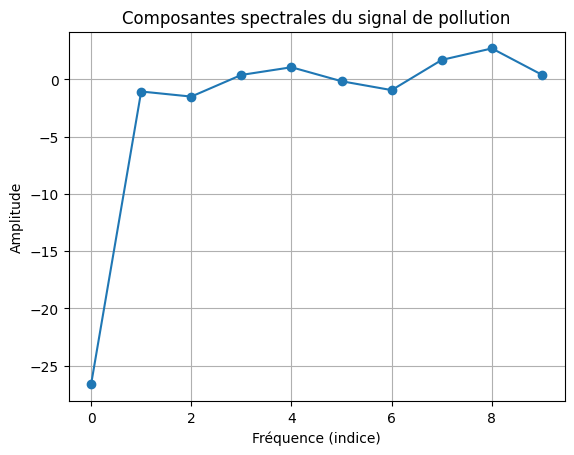

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

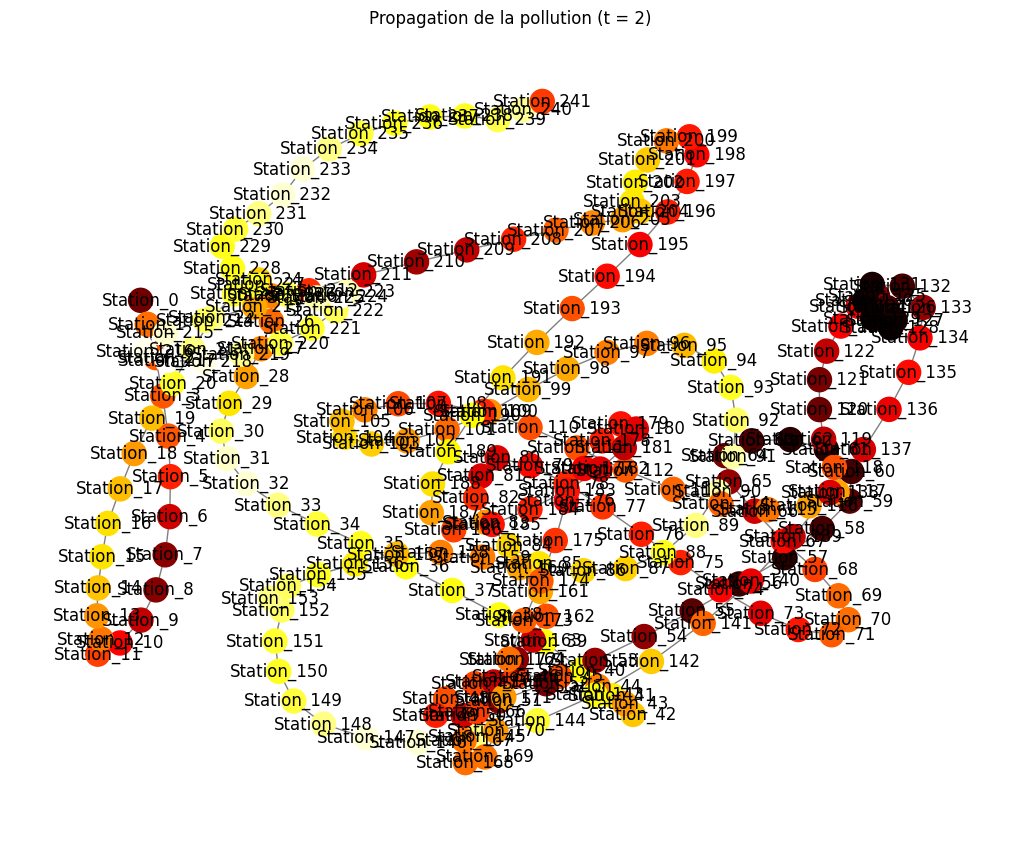

In [5]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh, expm_multiply
import matplotlib.pyplot as plt

# === 1. Chargement du fichier réel
df = pd.read_csv("../Data/processed/trajets_stations_pollution.csv")

# Génération de noms de stations fictifs
df["station1"] = ["Station_" + str(i) for i in range(len(df))]
df["station2"] = ["Station_" + str(i + 1) for i in range(len(df))]

# Dictionnaire pour convertir pollution textuelle en score numérique
pollution_mapping = {
    "pollution faible": 1,
    "pollution moyenne": 2,
    "pollution élevée": 3
}

df["pollution_num_station1"] = df["pollution_station1"].map(pollution_mapping)
df["pollution_num_station2"] = df["pollution_station2"].map(pollution_mapping)

# === 2. Création du graphe
G = nx.Graph()
for _, row in df.iterrows():
    s1 = row["station1"]
    s2 = row["station2"]
    G.add_edge(s1, s2)

# === 3. Ajout des données de pollution à chaque station (sous forme numérique)
# Si une station apparaît plusieurs fois, on garde la moyenne
pollution_values = {}

for _, row in df.iterrows():
    pollution_values.setdefault(row["station1"], []).append(row["pollution_num_station1"])
    pollution_values.setdefault(row["station2"], []).append(row["pollution_num_station2"])

pollution_avg = {station: np.mean(vals) for station, vals in pollution_values.items()}
nx.set_node_attributes(G, pollution_avg, "pollution")

# === 4. Matrice laplacienne
A = nx.adjacency_matrix(G, nodelist=list(G.nodes()))
L = csgraph.laplacian(A, normed=True)

# === 5. Transformée de Fourier sur graphe
station_list = list(G.nodes())
f = np.array([G.nodes[station].get("pollution", 0) for station in station_list])

# Décomposition spectrale
k = min(10, len(station_list) - 1)
eigvals, eigvecs = eigsh(L, k=k, which='SM')
U = eigvecs
f_hat = U.T @ f

# === 6. Affichage des composantes spectrales
plt.plot(f_hat, marker='o')
plt.title("Composantes spectrales du signal de pollution")
plt.xlabel("Fréquence (indice)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# === 7. Propagation simulée (équation de chaleur sur graphe)
t = 2.0
f_t = expm_multiply(-t * L, f)

# Met à jour les nœuds avec la pollution propagée
for station, val in zip(station_list, f_t):
    G.nodes[station]["pollution_diffused"] = val

# === 8. Visualisation du graphe coloré par pollution propagée
colors = [G.nodes[n].get("pollution_diffused", 0) for n in G.nodes()]
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=colors, cmap="hot", node_size=300, edge_color="gray")
plt.title("Propagation de la pollution (t = 2)")
plt.colorbar(plt.cm.ScalarMappable(cmap="hot"), label="Pollution propagée")
plt.show()


In [6]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
import numpy as np

# Matrice d’adjacence
A = nx.adjacency_matrix(G)

# Matrice laplacienne normalisée
L = csgraph.laplacian(A, normed=True)

# Décomposition spectrale : k plus petites valeurs propres
k = 10
eigvals, eigvecs = eigsh(L, k=k, which='SM')  # small magnitude
